### Задание 1

In [1]:
# Установка razdel: ее нет в Colab по умолчанию
!pip install razdel --q
!pip install wget --q

  Preparing metadata (setup.py) ... done


In [2]:
# Регулярные выражения потребуются для очистки текста
import re

from razdel import sentenize

# Без torch невозможна работа с нейросетями
import torch

# Библиотека transformers нужна для работы с нейросетями-трансформерами,
# которые мы будем использовать для анализа тональности
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Библиотека matplotlib позволит построить графики кривых тональности
from matplotlib import pyplot as plt

# Фильтр Савицкого-Голея понадобится нам для обработки результатов,
# которая будет описана позже
from scipy.signal import savgol_filter

In [4]:
import wget
# Прочитаем текст из целевого файла.
# Не забудьте загрузить его, используя вкладку "Файлы" слева сбоку
wget.download("https://github.com/DariaGugnyaeva/files/raw/refs/heads/main/agatha/0.txt")

'0.txt'

In [5]:
with open('0.txt', encoding='utf-8') as agatha:
    text = agatha.read()

In [6]:
def clean_text(text: str) -> str:
    # Заменяем переносы строк на пробелы, убираем лишние пробелы
    text = text.replace('\n', ' ')
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [7]:
# Очистим текст
cleaned_text = clean_text(text)

Чтобы провести динамический анализ тональности, нужно разбить текст на атомарные единицы, которые будут подаваться на вход нейросети. Они не должны быть слишком маленькими, так как в этом случае модель перестанет чувствовать контекст и потеряет своё главное преимущество перед словарём. Они не должны быть и слишком большими, так как размерности входного слоя нейросети может не хватить. В случае книг в качестве этих атомарных единиц лучше всего использовать предложения. Предложения достаточно маленькие по размеру, но выражают законченную мысль.

In [8]:
# Разобьем текст на предложения (используйте функцию sentenize) и загрузим их в список
# https://github.com/natasha/razdel?ysclid=m7nouiyl3u949621675
sentences = []

for i in list(sentenize(cleaned_text)):
    sentences.append(i.text)

In [67]:
# Загрузим модель с сайта HuggingFace и создадим ее экземпляр.
# Возможно модели нужно будет скачаться в Colab, нужно подождать.
# model_checkpoint = 'cointegrated/rubert-tiny-sentiment-balanced'
# tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
# model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)
# if torch.cuda.is_available():
#    model.cuda()

# Сложная функция, которая заставит модель работать
def estimate_sentiment(messages: list, model_checkpoint: str, options: list) -> list:
    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
    model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)
    if torch.cuda.is_available():
        model.cuda()
    sentiment_out = []
    for text in messages:
        with torch.no_grad():
            inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True).to(model.device)
            proba = torch.sigmoid(model(**inputs).logits).cpu().numpy()[0]
            sentiment_out.append(proba.dot(options))
    return sentiment_out

In [68]:
# Произведем нейросетевую оценку тональности
sentiments = estimate_sentiment(sentences, 'cointegrated/rubert-tiny-sentiment-balanced', [-1, 0, 1])

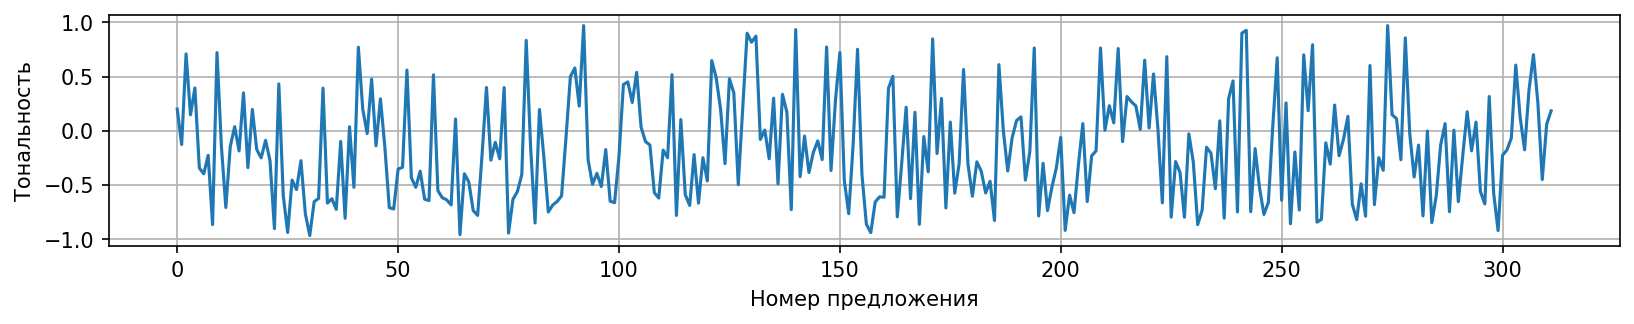

In [62]:
# Построим график кривой эмоциональной тональности с помощью matplotlib.
# Укажите разрешение графика 150, название оси X — "Номер предложения", оси Y — "Тональность". Добавьте отображение сетки.

plt.figure(figsize=(13, 2), dpi=150)
plt.plot(sentiments)
plt.xlabel("Номер предложения")
plt.ylabel("Тональность")
plt.grid()

Получилось не очень понятно и наглядно. При внимательном рассмотрении можно разглядеть очертания некоторой формы, сильно искажённой скачками и перепадами. Дело в том, что тональность предложений внутри текста может испытывать резкие перепады, а нейросеть может иногда ошибаться. В результате  возникают шумы и некоторая неустойчивость оценки.  


Проблему можно было бы решить, используя в качестве атомарных единиц фрагменты текста большего размера, например, главы. Это не универсальный подход, так как его результаты станут сильно разниться в зависимости от объёмов текста. Решим задачу более изящно и применим фильтры, пришедшие к нам из теории обработки сигналов и призванные отделять полезный сигнал от шумов, которые возникают при его передаче. Выберем фильтр Савицкого-Голея. Этот фильтр уже реализован в Python, мы импортировали его в самом начале.

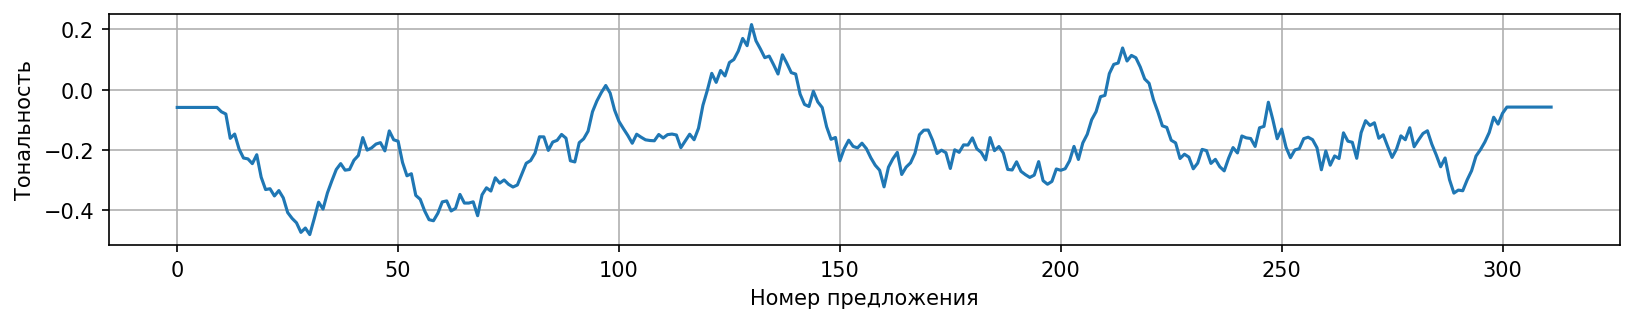

In [63]:
# Произведем фильтрацию сигнала фильтром Савицкого-Голея
filtered_sentiments = savgol_filter(sentiments, window_length=len(sentiments)//15, polyorder=0)

# Заново постройте график кривой эмоциональной тональности с теми же настройками.

plt.figure(figsize=(13, 2), dpi=150)
plt.plot(filtered_sentiments)
plt.xlabel("Номер предложения")
plt.ylabel("Тональность")
plt.grid()

У фильтра Савицкого-Голея есть параметр ``window_length``, который отвечает за размер окна сглаживания. Выбранное нами по умолчанию значение даёт хорошую картинку, но результаты использования фильтра во многом зависят от выбранного размера окна.

Малые окна сглаживают высокочастотный шум, устраняя мелкие флуктуации, а большие окна сглаживают более крупные колебания и тренды сигнала, оставляя только общие тенденции его поведения. Как найти баланс между размерами окна?

Чтобы получить более гладкую кривую, учитывающую основные тренды исходного графика, можно использовать ансамблевый фильтр. Для этого нужно параллельно обработать зашумлённую кривую несколькими фильтрами Савицкого-Голея с различными размером окна, после чего усреднить результаты всех фильтров. Предполагается, что наиболее значимые изгибы зашумленной кривой тональности окажутся наиболее устойчивыми к сглаживанию большинства фильтров, поэтому будут отражены в окончательном результате.

In [14]:
import math

In [70]:
# Ансамблевый фильтр
def ensemble_filter(data: list, n_filters=100, polyorder=0, **savgol_args) -> list:
    """
    Применяет ансамблевый фильтр к входным данным

    Parameters:
    data (list): входной массив данных
    n_filters (int, optional): число фильтров, участвующих в сглаживании
    """
    # Заведите переменную, в которую будете собирать сумму результатов
    # работы фильтров Савицкого-Голея.
    counter = 0
    # Вам нужно будет поочерёдно перебирать значения window_length для
    # того, чтобы обработать кривую тональности разными фильтрами.
    # Задайте стартовое и конечное значения window_length, а также шаг изменения,
    # поделённый на n_filters (чтобы значение шага было меньше единицы по итогу).
    # Если шаг получается дробным, округлите его до целого числа вверх.
    start = math.ceil(len(data) / 20)
    end = math.ceil(len(data) / 2)
    step = math.ceil((end - start) / n_filters)

    if step == 0:
        step = 1
    # window_length = w_l
    # Затем в цикле пройдитесь по всем значениям window_length, обработайте
    # фильтром Савицкого-Голея данные и приплюсуйте все значения в стартовую переменную.
    # В качестве результата функции верните стартовую переменную, разделённую на n_filters.
    for w_l in range(start, end, step):
        res = savgol_filter(data, window_length=w_l, polyorder=polyorder, **savgol_args)
        counter += res

    return counter/n_filters

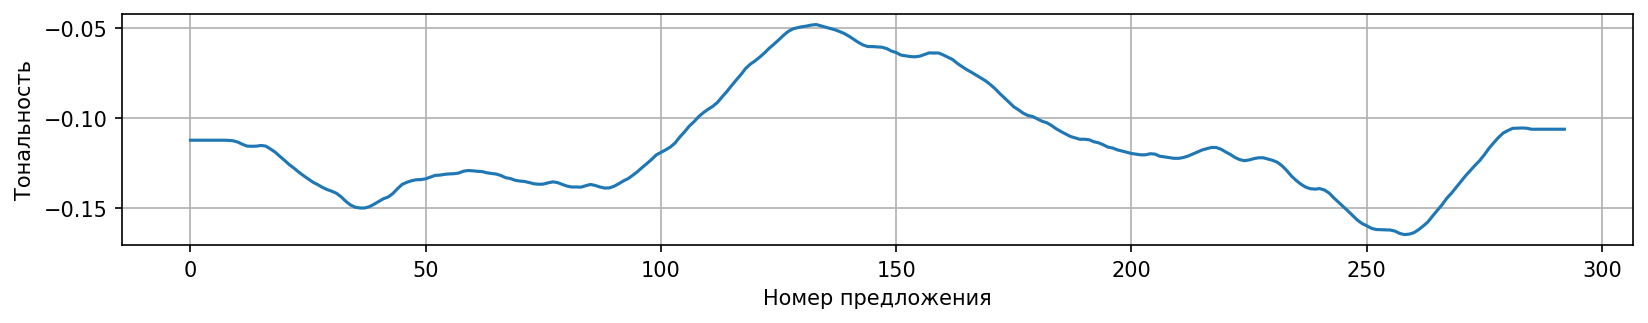

In [71]:
# Произведем фильтрацию сигнала ансамблевым фильтром

# ВАШ КОД ЗДЕСЬ
filtered_sentiments = ensemble_filter(sentiments)

# Заново постройте график кривой эмоциональной тональности с теми же настройками.

# ВАШ КОД ЗДЕСЬ
plt.figure(figsize=(13, 2), dpi=150)
plt.plot(filtered_sentiments)
plt.xlabel("Номер предложения")
plt.ylabel("Тональность")
plt.grid()

### Задание 2

Выберите несколько похожих на ваш взгляд произведений: одного автора, с похожим сюжетом или части одной серии. Проанализируйте их по очереди и отобразите кривые тональности на общем графике. Проанализируйте этот график и опишите ваши выводы. Обратите внимание: произведения должны быть примерно равны по длине либо необходимо пропорционально сжать/растянуть графики.

In [18]:
all_texts = []
for n in range(1, 10):
    wget.download(f"https://github.com/DariaGugnyaeva/files/raw/refs/heads/main/agatha/{n}.txt")
    with open(f'{n}.txt', encoding='utf-8') as agatha:
        all_texts.append(agatha.read())

In [48]:
import matplotlib.colors as colors

colors_list = list(colors._colors_full_map.values())

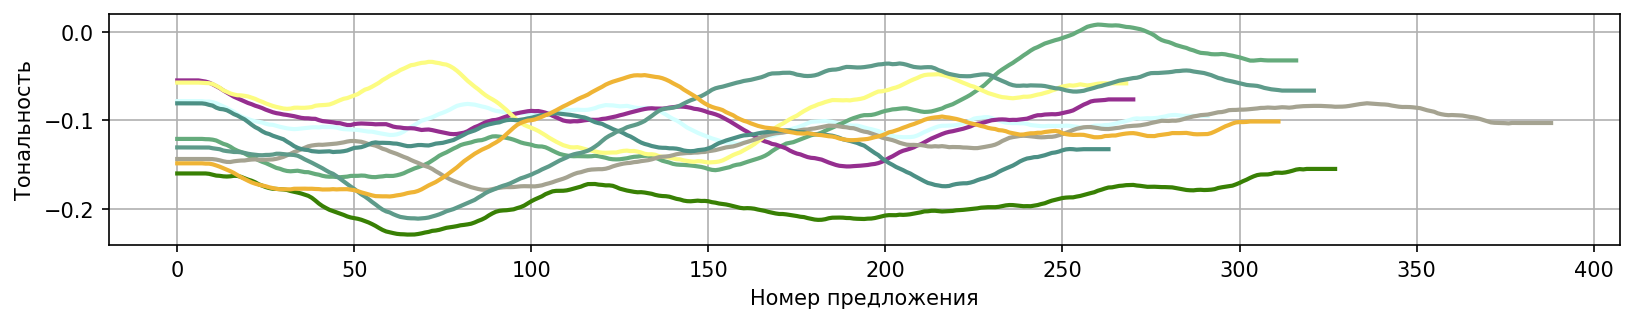

In [73]:
fig, ax = plt.subplots(figsize=(13, 2), dpi=150)

for k, text in enumerate(all_texts):
    cleaned_text = clean_text(text)
    sentences = []

    for i in list(sentenize(cleaned_text)):
        sentences.append(i.text)

    sentiments = estimate_sentiment(sentences, 'cointegrated/rubert-tiny-sentiment-balanced', [-1, 0, 1])
    filtered_sentiments = ensemble_filter(sentiments)
    ax.plot(filtered_sentiments, color=colors_list[k+7], linewidth=2)
    # с шагом почему-то не работало
plt.xlabel("Номер предложения")
plt.ylabel("Тональность")
plt.grid()

Графики разные, но построены по одной логике -- 2 холма и 2 сильно проседающих участка. Есть исключения, но в цеееелом...Видимо, завязка и кульминация в роли холмиков

### Задание 3

Попробуйте использовать другую модель с [HuggingFace](https://huggingface.co/models), выбрав такую, чтобы она была преобучена на русском языке и работала с анализом тональности. Сравните результаты, отличаются ли они?

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


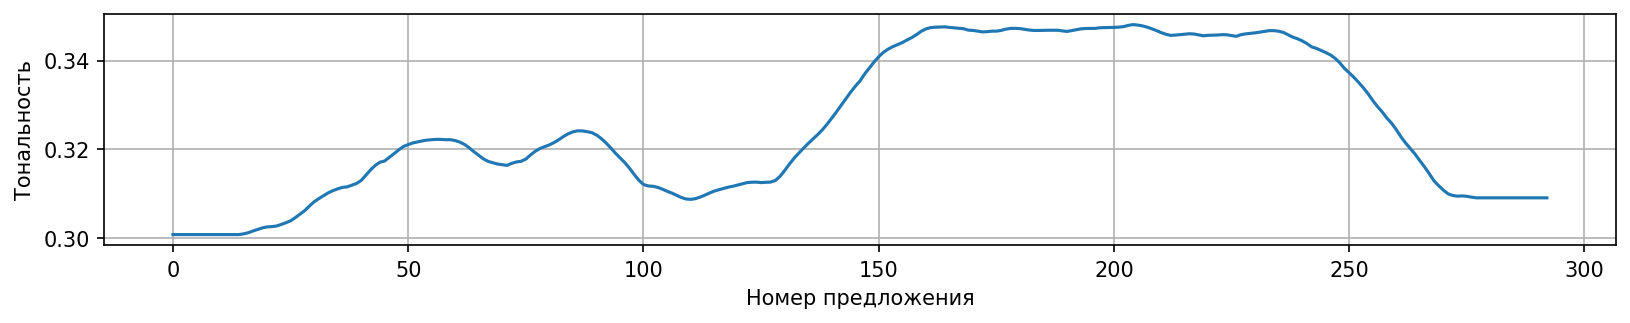

In [69]:
# data
with open('0.txt', encoding='utf-8') as agatha:
    text = agatha.read()

sentences = []
cleaned_text = clean_text(text)

for i in list(sentenize(cleaned_text)):
    sentences.append(i.text)

new_sentiments = estimate_sentiment(sentences, "RussianNLP/ruRoBERTa-large-rucola", [-1, 1])
filtered_sentiments = ensemble_filter(new_sentiments)

plt.figure(figsize=(13, 2), dpi=150)
plt.plot(filtered_sentiments)
plt.xlabel("Номер предложения")
plt.ylabel("Тональность")
plt.grid()

Ниже результат первой модели, не учитывающей нейтральные предложения (как я поняла).  И результаты явно отличаются

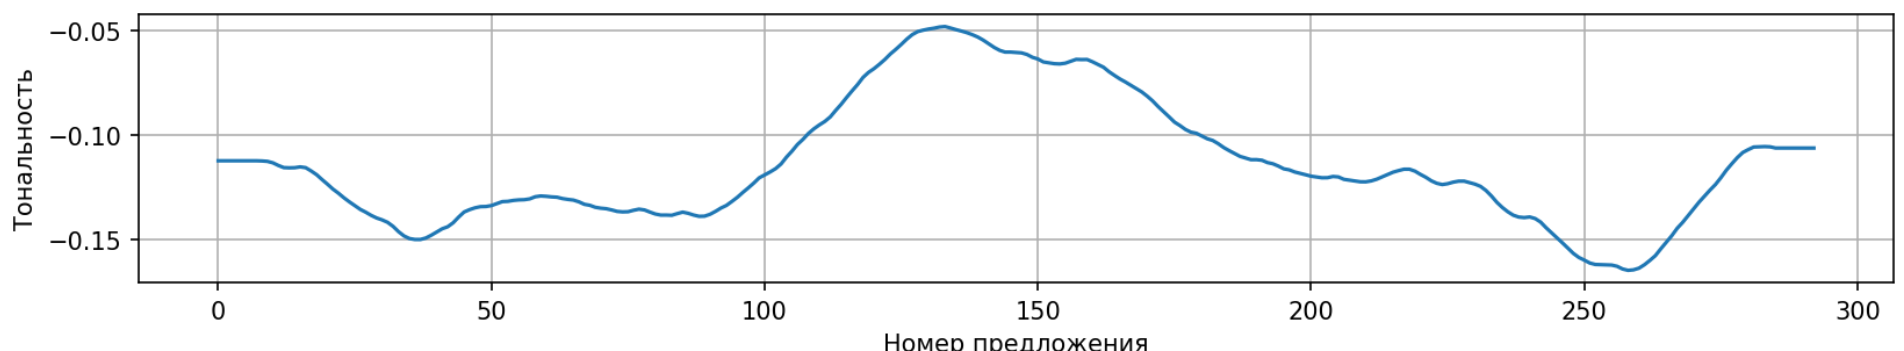